<a href="https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/nvt_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Temperature Simulation

Here we demonstrate some code to run a simulation at in the NVT ensemble. We start off by setting up some parameters of the simulation. This will include a temperature schedule that will start off at a high temperature and then instantaneously quench to a lower temperature.

In [59]:
N = 5000
dimension = 2
box_size = 80.0
dt = 1e-3
displacement, shift = space.periodic(box_size) 

T_schedule = lambda t: np.where(t < 1000.0 * dt, 0.5, 0.3)

Next we need to generate some random positions as well as particle sizes.

In [60]:
key = random.PRNGKey(0)

In [61]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [62]:
energy_fn = jit(energy.soft_sphere_pair(
    displacement, species=species, sigma=sigma, epsilon=10.0))

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, T_schedule, tau=3)
apply = jit(apply)
state = init(key, R)

Now let's actually do the simulation. We'll keep track of the temperature as well as the extended Hamiltonian of the Nose-Hoover dynamics.

In [63]:
def invariant(T, state):
  """The conserved quantity for Nose-Hoover thermostat."""
  accum = energy_fn(state.position) + \
          quantity.kinetic_energy(state.velocity, state.mass)
  N, dim = state.position.shape
  DOF = N * dim
  accum = accum + state.v_xi[0] ** 2 * state.Q[0] * 0.5 + \
      DOF * T * state.xi[0]
  for xi, v_xi, Q in zip(
      state.xi[1:], state.v_xi[1:], state.Q[1:]):
    accum = accum + v_xi ** 2 * Q * 0.5 + T * xi
  return accum

In [64]:
T = []
H = []

print_every = 50
old_time = time.clock()
print('Step\tT_goal\tT\ttime/step')
print('----------------------------------------')

for i in range(2000):
  t = i * dt
  state = apply(state, t=t)
  T += [quantity.temperature(state.velocity)]
  H += [invariant(T_schedule(t), state)]
  state = apply(state, t=t)
  
  if i % print_every == 0 and i > 0:
    new_time = time.clock()
    print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(
        i, T_schedule(t), T[-1], (new_time - old_time) / print_every))
    old_time = new_time
    
T = np.array(T)
H = np.array(H)
R = state.position

Step	T_goal	T	time/step
----------------------------------------
50	0.500	0.502	0.166
100	0.500	0.506	0.026
150	0.500	0.505	0.026
200	0.500	0.505	0.026
250	0.500	0.502	0.026
300	0.500	0.496	0.026
350	0.500	0.488	0.025
400	0.500	0.487	0.026
450	0.500	0.493	0.026
500	0.500	0.490	0.026
550	0.500	0.498	0.026
600	0.500	0.506	0.026
650	0.500	0.515	0.026
700	0.500	0.505	0.026
750	0.500	0.495	0.025
800	0.500	0.494	0.026
850	0.500	0.490	0.026
900	0.500	0.495	0.026
950	0.500	0.503	0.026
1000	0.300	0.492	0.026
1050	0.300	0.301	0.025
1100	0.300	0.303	0.026
1150	0.300	0.297	0.026
1200	0.300	0.306	0.025
1250	0.300	0.302	0.026
1300	0.300	0.293	0.026
1350	0.300	0.296	0.026
1400	0.300	0.301	0.025
1450	0.300	0.309	0.026
1500	0.300	0.304	0.026
1550	0.300	0.304	0.026
1600	0.300	0.298	0.026
1650	0.300	0.294	0.026
1700	0.300	0.294	0.026
1750	0.300	0.299	0.026
1800	0.300	0.308	0.026
1850	0.300	0.304	0.026
1900	0.300	0.306	0.026
1950	0.300	0.300	0.025


Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

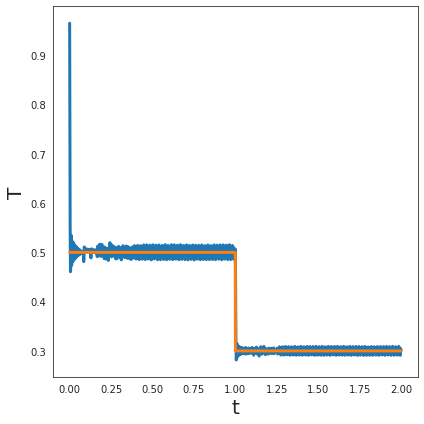

In [65]:
t = onp.arange(0, 2000) * dt
T = onp.array(T)
plt.plot(t, T, linewidth=3)
plt.plot(t, onp.array(T_schedule(t)), linewidth=3)
format_plot('t', 'T')
finalize_plot()

Now let's plot the Hamiltonian of the system. We see that it is invariant apart from changes to the temperature, as expected.

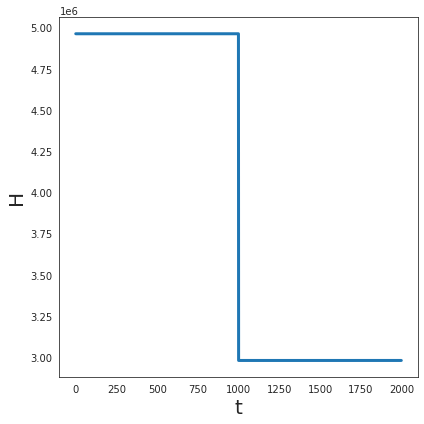

In [70]:
plt.plot(H, linewidth=3)
format_plot('t', 'H')
finalize_plot()

Now let's plot the system.

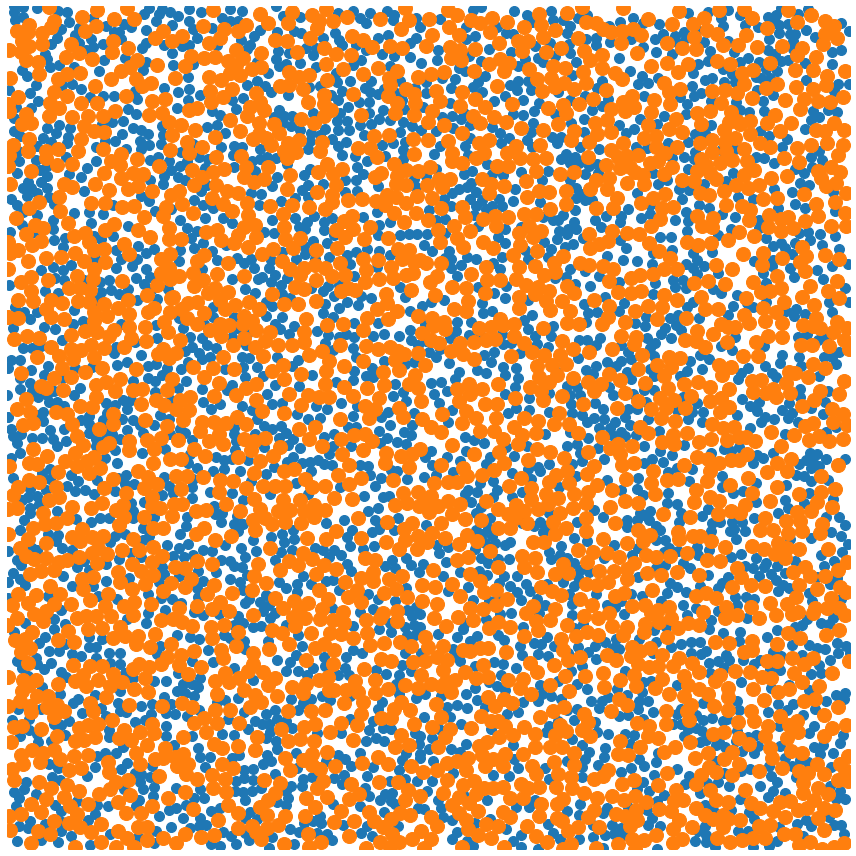

In [67]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [68]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


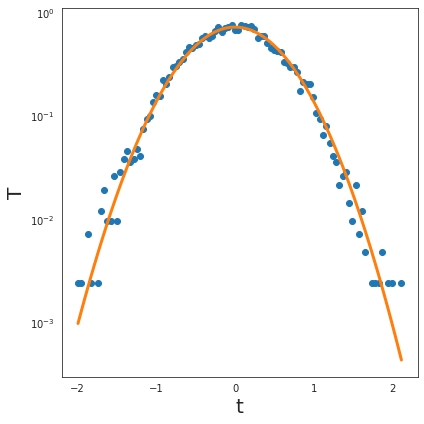

In [71]:
T_cur = T_schedule(20.0)
plt.semilogy(bins[:-1], occ, 'o')
plt.semilogy(
    bins[:-1], 
    1.0 / np.sqrt(2 * np.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()